In [3]:
# 1 Initialisation

from dateutil.parser import parse
import matplotlib as mpl #matplotlib library for visualization
import matplotlib.pyplot as plt
import seaborn as sns #high-level interface for visualization
import numpy as np #tools for working with multidimensional arrays
import pandas as pd #data analysis

# Import as Dataframe
df = pd.read_csv('time_series_one_pixel.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)
df['date']

0     2005-01-01
1     2005-01-09
2     2005-01-17
3     2005-01-25
4     2005-02-02
         ...    
501   2015-11-25
502   2015-12-03
503   2015-12-11
504   2015-12-19
505   2015-12-27
Name: date, Length: 506, dtype: datetime64[ns]

In [ ]:
# 2.1 visualizing time series

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='NDVI', dpi=300):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df['date'], y=df['value'], title='NDVI in selected pixel in Castilla La Mancha from 2005 to 2015.') 

# Historgram
fig, ax = plt.subplots(figsize=(5,4))
df['value'].hist(ax=ax, edgecolor='black', linewidth=0.5, grid=False)

# 添加 x 和 y 轴标签
ax.set_xlabel("NDVI")
ax.set_ylabel("Count")

plt.show()

In [ ]:
# 2.2 Visualisation: Seasonal Plot of a Time Series

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()
print(df)

# calssify by 'year' + 'month'  and get mean
df_mean = df.groupby(['year', 'month'])['value'].mean()
df_mean = df_mean.reset_index()

df_mean['month'] = pd.to_datetime(df_mean['month'], format='%b')
df_mean = df_mean.sort_values(['year','month'])
df_mean['month'] = [d.strftime('%b') for d in df_mean['month']]
#df_mean= df_mean.reset_index()

# Prep Colors
np.random.seed(20)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 300)
for i, y in enumerate(years):
     if i > 0:        
        plt.plot('month', 'value', data=df_mean.loc[df_mean['year']==y, :], color=mycolors[i], label=y)
        plt.text(df_mean.loc[df_mean['year']==y, :].shape[0]-.9, df_mean.loc[df_mean['year']==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(ylabel='$NDVI$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of NDVI Time Series", fontsize=20)
plt.show()

In [ ]:
# 2.3 Visulisation: Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [ ]:
# 3.1 TS Decomposition

#Patterns in a time series
#Additive and multiplicative time series

from statsmodels.tsa.seasonal import seasonal_decompose

# Import Data
df = pd.read_csv('time_series_one_pixel.csv', parse_dates=['date'], index_col='date')
print(df)
# Multiplicative Decomposition (period = 46)
result_mul = seasonal_decompose(df['value'], model='multiplicative', period=46, extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', period=46, extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot()#.suptitle('Multiplicative Decompose', fontsize=18)
result_add.plot()#.suptitle('Additive Decompose', fontsize=18)
plt.show()

#numerical output of the trend, seasonal and residual components
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

In [ ]:
# 3.2 TS Detrend

# Using statmodels: Subtracting the Trend Component.
detrended = df.value.values - result_add.trend
plt.plot(detrended)
plt.title('NDVI detrended by subtracting the trend component', fontsize=16)

In [ ]:
# 3.3 TS Deseasonalize

# Subtracting the Trend Component.

# Deseasonalize
deseasonalized = df.value.values - result_add.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('NDVI deseasonalised by subtracting the trend component', fontsize=16)
plt.plot()

In [ ]:
# 4.1 TS Smoothing

#smooth a time series
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving Average
df_ma = df.value.rolling(3, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df.value, np.arange(len(df.value)), frac=0.05)[:, 1], index=df.index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(df.value, np.arange(len(df.value)), frac=0.15)[:, 1], index=df.index, columns=['value'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df['value'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('Time Series Smoothing', y=0.95, fontsize=14)
plt.show()

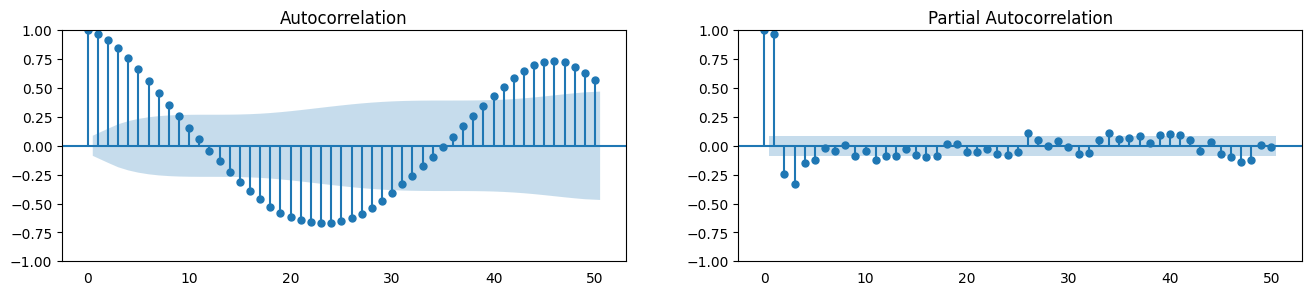

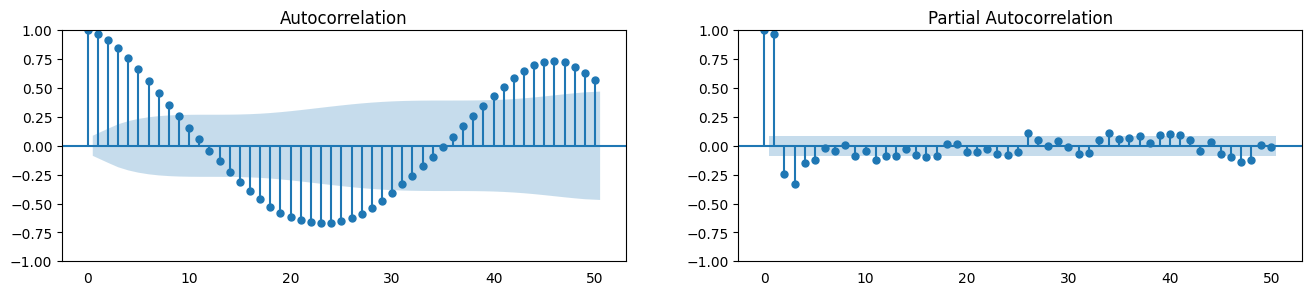

In [132]:
# 4.2 Autocorrelation and partial autocorrelation functions
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_csv('time_series_one_pixel.csv')

# Calculate ACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.value.tolist(), lags=50, ax=axes[0])
plot_pacf(df.value.tolist(), lags=50, ax=axes[1], method='ywm')



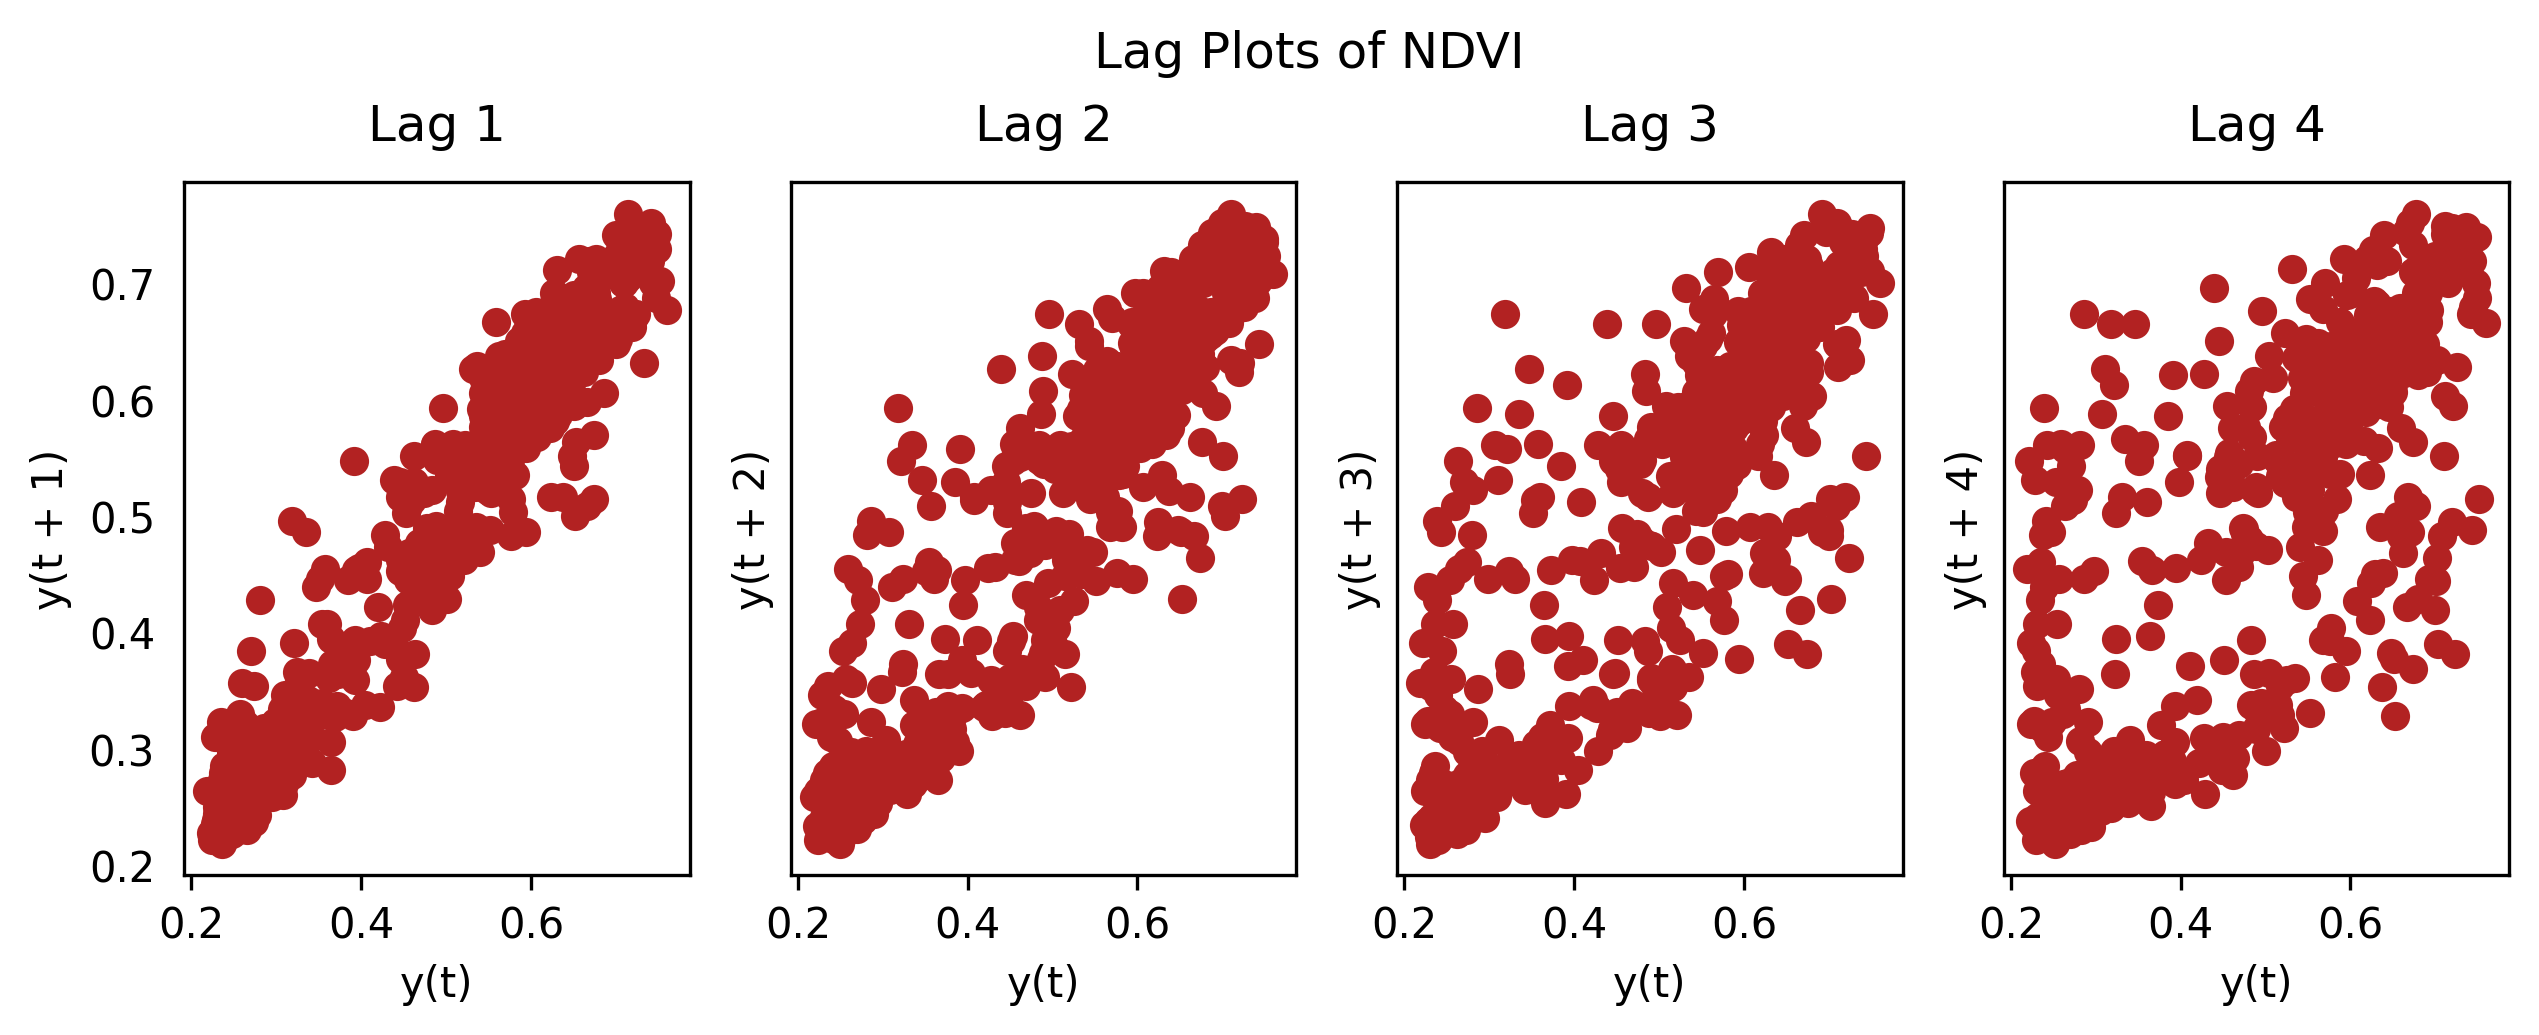

In [5]:
# 4.3 Lag Plot
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=300)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of NDVI', y=1.05)    

plt.show()